## Bond Portfolio Returns

In [16]:
import pandas as pd
import numpy as np
import wrds
import matplotlib.pyplot as plt
import scipy.stats as stats

# Load the bond data
data = pd.read_csv('../Downloads/data_bonda.csv')

# Convert 'MCALDT' column to datetime and extract year and month
data['MCALDT'] = pd.to_datetime(data['MCALDT'])
data['year'] = data['MCALDT'].dt.year
data['month'] = data['MCALDT'].dt.month

# Create a function to compute equal-weighted, value-weighted bond returns, and lagged total bond market capitalization
def PS2_Q1(df):
    """
    This function takes a DataFrame containing bond data and returns a DataFrame with equal-weighted bond market returns,
    value-weighted bond market returns, and lagged total bond market capitalization for each unique year and month.

    Parameters:
    df (DataFrame): A DataFrame containing bond data with columns: KYCRSPID, MCALDT, TMRETNUA, TMTOTOUT

    Returns:
    result (DataFrame): A DataFrame with columns: year, month, Bond Ew Ret, Bond Vw Ret, Bond lag MV
    """

    # Group by year and month
    grouped_df = df.groupby(['year', 'month'])
    
    # Compute equal-weighted returns
    ew_returns = grouped_df['TMRETNUA'].mean().reset_index()
    ew_returns = ew_returns.rename(columns={'TMRETNUA': 'Bond Ew Ret'})

    # Shift the market values by one period
    df['Lagged_TMTOTOUT'] = df.groupby(['year', 'month'])['TMTOTOUT'].transform('sum').shift(1)
    # Calculate weights using lagged market values
    df['Weight'] = df['TMTOTOUT'] / df['Lagged_TMTOTOUT']

    # Compute weighted returns
    df['Weighted_Return'] = df['Weight'] * df['TMRETNUA']
    vw_returns = df.groupby(['year', 'month'])['Weighted_Return'].sum().reset_index()
    vw_returns = vw_returns.rename(columns={'Weighted_Return': 'Bond Vw Ret'})
    
    # Compute lagged total bond market capitalization
    bond_lag_mv = grouped_df['TMTOTOUT'].sum().shift(1).reset_index()
    bond_lag_mv = bond_lag_mv.rename(columns={'TMTOTOUT': 'Bond lag MV'})

    # Merge all the results into a single DataFrame
    result = ew_returns.merge(vw_returns, on=['year', 'month']).merge(bond_lag_mv, on=['year', 'month'])
    
    return result

# Call the function with the bond_data DataFrame
output = PS2_Q1(data)
output.head()


,year,month,Bond Ew Ret,Bond Vw Ret,Bond lag MV
0,1926,1,0.005101,0.000075,NaN
1,1926,2,0.003621,0.006154,809.0
2,1926,3,0.003812,0.003881,809.0
3,1926,4,0.004014,0.007441,809.0
4,1926,5,0.002146,0.001472,809.0


## Stock and Bond Portfolio Excess Returns

In [64]:
# Query CRSP value-weighted index data
vw_index_data_query = """
SELECT date, VWRETD, totval
FROM crspq.msi
WHERE date >= '1926-01-01' AND date <= '2022-12-31'
"""
db = wrds.Connection()
vw_index_data = db.raw_sql(vw_index_data_query)

# Preprocess CRSP value-weighted index data
vw_index_data['date'] = pd.to_datetime(vw_index_data['date'])
vw_index_data['year'] = vw_index_data['date'].dt.year
vw_index_data['month'] = vw_index_data['date'].dt.month

riskless_data = pd.read_excel('Risk free.xlsx')

riskless_data['MCALDT'] = pd.to_datetime(riskless_data['MCALDT'])

riskless_data['year'] = riskless_data['MCALDT'].dt.year
riskless_data['month'] = riskless_data['MCALDT'].dt.month

vw_index_data['Stock lag MV'] = vw_index_data['totval'].shift(1)

# Merge the stock, bond, and riskless datasets
merged_data = pd.merge(vw_index_data, output, on=['year', 'month'], suffixes=('_stock', '_bond'))
merged_data = pd.merge(merged_data, riskless_data, left_on=['year', 'month'], right_on=['year', 'month'])

merged_data['monthly_rf'] = ((1 + merged_data['90day'])**(1/12)) - 1

merged_data['Stock Excess Vw Ret'] = merged_data['vwretd'] - merged_data['monthly_rf']
merged_data['Bond Excess Vw Ret'] = merged_data['Bond Vw Ret'] - merged_data['monthly_rf']

# Keep only the necessary columns
output_data = merged_data[['year', 'month', 'Stock lag MV', 'Stock Excess Vw Ret', 'Bond lag MV', 'Bond Excess Vw Ret']]

Enter your WRDS username [manish]:mabun
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [65]:
output_data

,year,month,Stock lag MV,Stock Excess Vw Ret,Bond lag MV,Bond Excess Vw Ret
0,1926,1,NaN,-0.002194,NaN,-0.002680
1,1926,2,2.762424e+07,-0.035621,809.0,0.003579
2,1926,3,2.675206e+07,-0.066567,809.0,0.001316
3,1926,4,2.508317e+07,0.034487,809.0,0.004899
4,1926,5,2.588674e+07,0.009443,809.0,-0.001180
...,...,...,...,...,...,...
1159,2022,8,5.380883e+10,-0.038519,22603310.0,-0.021204
1160,2022,9,5.174570e+10,-0.094032,23066079.0,-0.026777
1161,2022,10,4.693000e+10,0.074091,23063239.0,-0.012282
1162,2022,11,5.041474e+10,0.048902,23165355.0,0.018560


## Levered and Unlevered Risk Parity Portfolio


In [66]:
def PS2_Q3(df):
    # Calculate Excess Value-weighted Ret and Excess 60-40 Ret
    df['Excess_Vw_Ret'] = (df['Stock Excess Vw Ret'] + df['Bond Excess Vw Ret']) / 2
    df['Excess_60_40_Ret'] = 0.6 * df['Stock Excess Vw Ret'] + 0.4 * df['Bond Excess Vw Ret']

    # Calculate inverse sigma hat for stocks and bonds
    df['Stock_inverse_sigma_hat'] = 1 / df['Stock Excess Vw Ret'].rolling(window=36).std()
    df['Bond_inverse_sigma_hat'] = 1 / df['Bond Excess Vw Ret'].rolling(window=36).std()

    # Calculate Unlevered k
    df['Unlevered_k'] = df['Stock_inverse_sigma_hat'] + df['Bond_inverse_sigma_hat']

    # Calculate Excess Unlevered RP Ret
    df['Excess_Unlevered_RP_Ret'] = ((df['Stock Excess Vw Ret'] * df['Stock_inverse_sigma_hat']) +
                                     (df['Bond Excess Vw Ret'] * df['Bond_inverse_sigma_hat'])) / df['Unlevered_k']

    # Calculate Levered k to match the sigma_hat of Excess_Vw_Ret
    sigma_hat_vw = df['Excess_Vw_Ret'].rolling(window=36).std().mean()
    sigma_hat_rp = df['Excess_Unlevered_RP_Ret'].rolling(window=36).std().mean()
    df['Levered_k'] = sigma_hat_vw / sigma_hat_rp

    # Calculate Excess Levered RP Ret
    df['Excess_Levered_RP_Ret'] = df['Excess_Unlevered_RP_Ret'] * df['Levered_k']

    # Keep only the necessary columns
    output_columns = ['year', 'month', 'Stock Excess Vw Ret', 'Bond Excess Vw Ret', 'Excess_Vw_Ret', 'Excess_60_40_Ret',
                      'Stock_inverse_sigma_hat', 'Bond_inverse_sigma_hat', 'Unlevered_k', 'Excess_Unlevered_RP_Ret',
                      'Levered_k', 'Excess_Levered_RP_Ret']
    output_data = df[output_columns]

    return output_data

# Call the function with the output_data DataFrame from Q2
result_q3 = PS2_Q3(output_data)
result_q3.head()


/var/folders/ht/n4tztbqj3x31zbxl5pn4x9500000gn/T/ipykernel_86911/660766578.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Excess_Vw_Ret'] = (df['Stock Excess Vw Ret'] + df['Bond Excess Vw Ret']) / 2
/var/folders/ht/n4tztbqj3x31zbxl5pn4x9500000gn/T/ipykernel_86911/660766578.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Excess_60_40_Ret'] = 0.6 * df['Stock Excess Vw Ret'] + 0.4 * df['Bond Excess Vw Ret']
/var/folders/ht/n4tztbqj3x31zbxl5pn4x9500000gn/T/ipykernel_86911/660766578.py:9: Settin

,year,month,Stock Excess Vw Ret,Bond Excess Vw Ret,Excess_Vw_Ret,Excess_60_40_Ret,Stock_inverse_sigma_hat,Bond_inverse_sigma_hat,Unlevered_k,Excess_Unlevered_RP_Ret,Levered_k,Excess_Levered_RP_Ret
0,1926,1,-0.002194,-0.002680,-0.002437,-0.002388,NaN,NaN,NaN,NaN,2.502231,NaN
1,1926,2,-0.035621,0.003579,-0.016021,-0.019941,NaN,NaN,NaN,NaN,2.502231,NaN
2,1926,3,-0.066567,0.001316,-0.032625,-0.039414,NaN,NaN,NaN,NaN,2.502231,NaN
3,1926,4,0.034487,0.004899,0.019693,0.022651,NaN,NaN,NaN,NaN,2.502231,NaN
4,1926,5,0.009443,-0.001180,0.004131,0.005194,NaN,NaN,NaN,NaN,2.502231,NaN


In [42]:
risk_free_d

,MCALDT,30day,90day,year,month
0,1926-01-30,0.036735,0.033565,1926,1
1,1926-02-27,0.031344,0.031344,1926,2
2,1926-03-31,0.031218,0.031218,1926,3
3,1926-04-30,0.027242,0.030935,1926,4
4,1926-05-28,0.032295,0.032295,1926,5
...,...,...,...,...,...
1159,2022-08-31,0.023548,0.027697,2022,8
1160,2022-09-30,0.027255,0.032984,2022,9
1161,2022-10-31,0.034574,0.040380,2022,10
1162,2022-11-30,0.039844,0.042245,2022,11


# Visualization of results 

/var/folders/ht/n4tztbqj3x31zbxl5pn4x9500000gn/T/ipykernel_86911/2951640210.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_q3['date'] = pd.to_datetime(result_q3[['year', 'month']].assign(day=1))


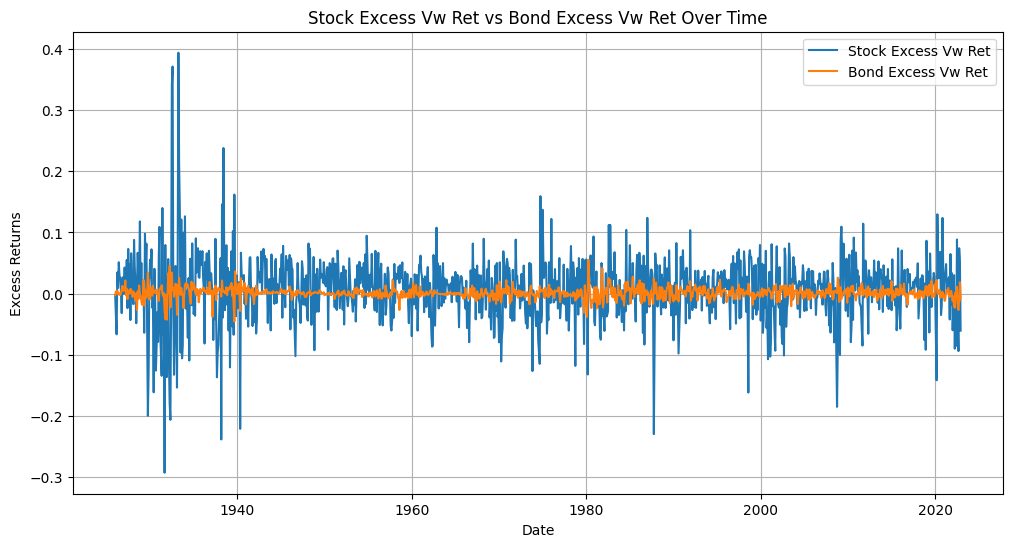

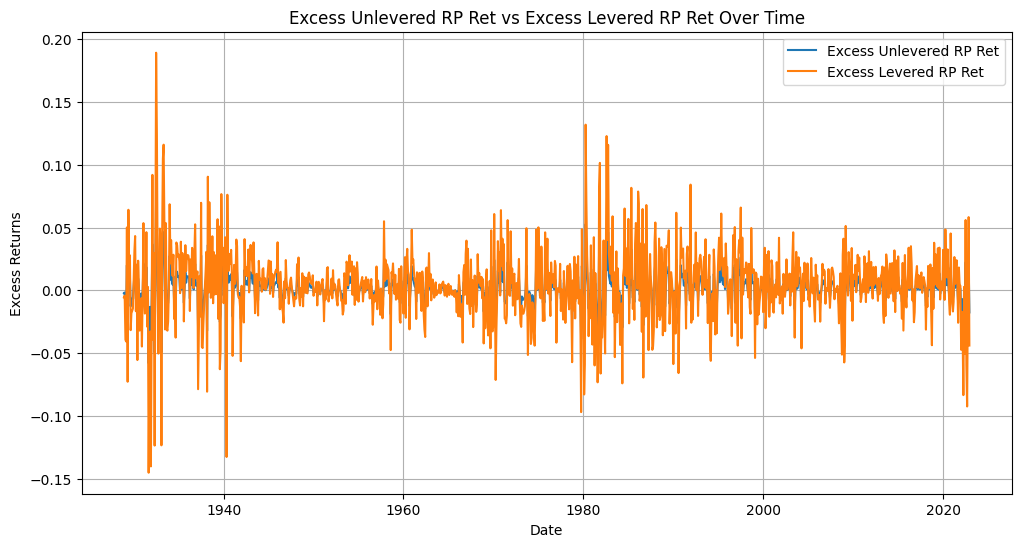

In [67]:
# Create a new column for the date
result_q3['date'] = pd.to_datetime(result_q3[['year', 'month']].assign(day=1))

# Plot Stock Excess Vw Ret and Bond Excess Vw Ret on the same chart
plt.figure(figsize=(12, 6))
plt.plot(result_q3['date'], result_q3['Stock Excess Vw Ret'], label='Stock Excess Vw Ret')
plt.plot(result_q3['date'], result_q3['Bond Excess Vw Ret'], label='Bond Excess Vw Ret')
plt.xlabel('Date')
plt.ylabel('Excess Returns')
plt.title('Stock Excess Vw Ret vs Bond Excess Vw Ret Over Time')
plt.legend()
plt.grid()
plt.show()

# Plot Excess_Unlevered_RP_Ret and Excess_Levered_RP_Ret on the same chart
plt.figure(figsize=(12, 6))
plt.plot(result_q3['date'], result_q3['Excess_Unlevered_RP_Ret'], label='Excess Unlevered RP Ret')
plt.plot(result_q3['date'], result_q3['Excess_Levered_RP_Ret'], label='Excess Levered RP Ret')
plt.xlabel('Date')
plt.ylabel('Excess Returns')
plt.title('Excess Unlevered RP Ret vs Excess Levered RP Ret Over Time')
plt.legend()
plt.grid()
plt.show()


## Comparison of Moments of Diff Strategies

In [72]:
def PS2_Q4(Port_Rets):
    # Filter data between January 1930 and June 2010
    filtered_data = Port_Rets[(Port_Rets['year'] >= 1930) & (Port_Rets['year'] < 2010) | ((Port_Rets['year'] == 2010) & (Port_Rets['month'] <= 6))]
    
    strategies = ['Stock Excess Vw Ret', 'Bond Excess Vw Ret', 'Excess_Vw_Ret', 'Excess_60_40_Ret', 'Excess_Unlevered_RP_Ret', 'Excess_Levered_RP_Ret']
    statistics = ['Annualized Mean', 't-stat of Annualized Mean', 'Annualized Standard Deviation', 'Annualized Sharpe Ratio', 'Skewness', 'Excess Kurtosis']
    
    results = pd.DataFrame(index=strategies, columns=statistics)
    
    for strategy in strategies:
        ret = filtered_data[strategy]
        
        annualized_mean = np.mean(ret) * 12
        t_stat = (np.mean(ret) / (np.std(ret, ddof=1) / np.sqrt(len(ret))))
        annualized_std = np.std(ret, ddof=1) * np.sqrt(12)
        annualized_sharpe_ratio = annualized_mean / annualized_std
        skewness = stats.skew(ret)
        excess_kurtosis = stats.kurtosis(ret)
        
        results.loc[strategy] = [annualized_mean, t_stat, annualized_std, annualized_sharpe_ratio, skewness, excess_kurtosis]
    
    return results
result_q4 = PS2_Q4(result_q3)
print(result_q4)


                        Annualized Mean t-stat of Annualized Mean  \
Stock Excess Vw Ret            0.069381                  3.279311   
Bond Excess Vw Ret             0.013359                  3.800043   
Excess_Vw_Ret                   0.04137                  3.763238   
Excess_60_40_Ret               0.046972                  3.615999   
Excess_Unlevered_RP_Ret        0.020781                  4.579528   
Excess_Levered_RP_Ret          0.051998                  4.579528   

                        Annualized Standard Deviation Annualized Sharpe Ratio  \
Stock Excess Vw Ret                          0.189825                0.365498   
Bond Excess Vw Ret                           0.031542                0.423536   
Excess_Vw_Ret                                0.098633                0.419434   
Excess_60_40_Ret                             0.116549                0.403023   
Excess_Unlevered_RP_Ret                      0.040714                0.510414   
Excess_Levered_RP_Ret         

In [73]:
result_q4

,Annualized Mean,t-stat of Annualized Mean,Annualized Standard Deviation,Annualized Sharpe Ratio,Skewness,Excess Kurtosis
Stock Excess Vw Ret,0.069381,3.279311,0.189825,0.365498,0.284433,8.06585
Bond Excess Vw Ret,0.013359,3.800043,0.031542,0.423536,-0.057988,5.149367
Excess_Vw_Ret,0.04137,3.763238,0.098633,0.419434,0.275195,7.955863
Excess_60_40_Ret,0.046972,3.615999,0.116549,0.403023,0.282373,8.026524
Excess_Unlevered_RP_Ret,0.020781,4.579528,0.040714,0.510414,0.044054,5.068295
Excess_Levered_RP_Ret,0.051998,4.579528,0.101875,0.510414,0.044054,5.068295
